Load the Model

In [1]:
from tensorflow.keras.models import load_model

model = load_model("../logs/tacobinary-generator-ranger-1e-4-bce_dice/model-best.h5", compile=False)

# define preprocessing parameters
input_size = tuple(model.input.shape[1:3])
color_mode = 0 if model.input.shape[-1] == 3 else 1
num_classes = 2 if model.output.shape[-1] <= 2 else model.output.shape[-1]
scale_mask = model.output.shape[-1] == 1
resize_method = 'resize_with_pad'

print("input shape: ", model.input.shape)
print("output shape: ", model.output.shape)

input shape:  (None, 512, 512, 3)
output shape:  (None, 512, 512, 1)


## Prediction

Read an image or images, predict and show predictions

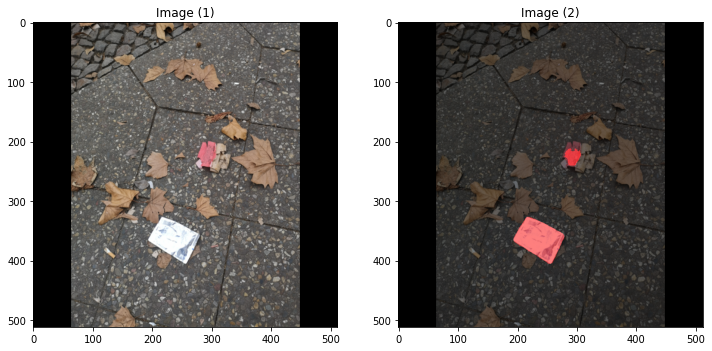

In [7]:
import imageio
import numpy as np
import random
from tf_semantic_segmentation.processing.dataset import resize_and_change_color
from tf_semantic_segmentation.visualizations import show, masks
from tf_semantic_segmentation import utils

# read a random image
files = utils.get_files("/home/baudcode/Documents/Plastic/", extensions=['jpg'])
image = imageio.imread(random.choice(files))
# image = imageio.imread('/home/baudcode/Documents/Plastic/IMG_20200103_124250.jpg')

# preprocessing
image = image / 255.
image, _ = resize_and_change_color(image, None, input_size, color_mode, resize_method=resize_method)
images = np.expand_dims(image, axis=0)

# predict
p = model.predict(images)

# show colored predictions
rgb = masks.get_colored_segmentation_mask(p, 2, images=images, binary_threshold=0.5, alpha=0.5)[0]
show.show_images([image, rgb])

Predict on the testset of a dataset

generating masks: 100%|██████████| 1500/1500 [00:00<00:00, 66276.78it/s]


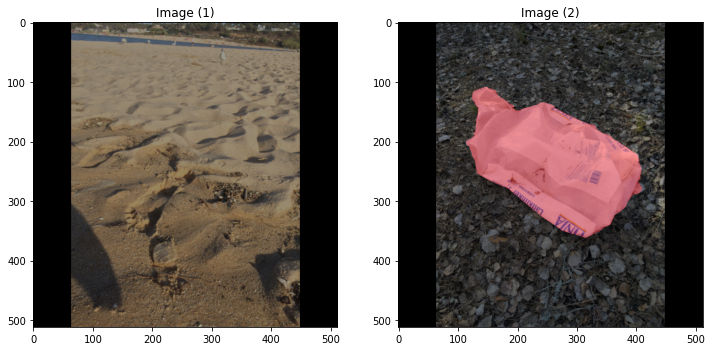

In [8]:
from tf_semantic_segmentation.datasets.plastic import TacoBinary
from tf_semantic_segmentation.datasets.utils import convert2tfdataset, DataType
from tf_semantic_segmentation.processing.dataset import get_preprocess_fn
from tf_semantic_segmentation.visualizations import show, masks

# get the dataset
ds = TacoBinary('/hdd/datasets/taco')

# convert to tensorflow dataset (use randomize=False to get the same examples everytime)
tfds = convert2tfdataset(ds, DataType.TEST, randomize=True)

# preprocess dataset
tfds = tfds.map(get_preprocess_fn(input_size, color_mode, resize_method, scale_mask=scale_mask))

# make batch and take 1 batch of 2 examples
tfds = tfds.batch(2).take(1)

# predict
for image_batch, target_batch in tfds:
    p = model.predict(image_batch)
    
# get colored predictions
rgb = masks.get_colored_segmentation_mask(p, num_classes, images=image_batch.numpy(), alpha=0.4)
show.show_images(rgb)